Using the cms_synthetic_claims.db from https://github.com/theradler/Hackathon25/tree/main/cms_synthetic_claims. Change the path to be your path

In [14]:
import pandas as pd
import sqlite3

# Connect to the local SQLite database
conn = sqlite3.connect('C:\\Workspace\\hack2\\Hackathon25-robert\\cms_synthetic_claims\\cms_synthetic_claims.db')

# Run the PRAGMA table_info command for each table
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables['name']:
    info = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(f"Table: {table}")
    print(info)
    print()

df_inpatient_claims = pd.read_sql_query("SELECT * FROM raw_cms_claims;", conn)
conn.close()

Table: raw_cms_claims
     cid                         name       type  notnull dflt_value  pk
0      0                      BENE_ID    INTEGER        0       None   0
1      1                       CLM_ID    INTEGER        0       None   0
2      2   NCH_NEAR_LINE_REC_IDENT_CD       TEXT        0       None   0
3      3              NCH_CLM_TYPE_CD    INTEGER        0       None   0
4      4                  CLM_FROM_DT  TIMESTAMP        0       None   0
..   ...                          ...        ...      ...        ...  ..
192  192     CLM_UNCOMPD_CARE_PMT_AMT       REAL        0       None   0
193  193                 CLM_LINE_NUM    INTEGER        0       None   0
194  194                     REV_CNTR    INTEGER        0       None   0
195  195                     HCPCS_CD       TEXT        0       None   0
196  196  REV_CNTR_DDCTBL_COINSRNC_CD       REAL        0       None   0

[197 rows x 6 columns]

Table: raw_cms_beneficiary_2025
     cid               name       type  notnu

In [26]:
#  this removal process is slow, lets build up what we want to keep instead
# df_inpatient_claims = df_inpatient_claims.drop(columns=['NCH_NEAR_LINE_REC_IDENT_CD']) # always 'V' because this is inpatient claims
# df_inpatient_claims = df_inpatient_claims.drop(columns=['NCH_CLM_TYPE_CD']) # always 60 because this is inpatient claims
# df_inpatient_claims = df_inpatient_claims.drop(columns=['FI_CLM_PROC_DT']) # always empty, The date the fiscal intermediary completes processing and releases the institutional claim
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLAIM_QUERY_CODE']) # always 3 Code indicating the type of claim record being processed with respect to payment. 3 is the final bill
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_FAC_TYPE_CD']) # always 1, 'Hospital' https://bluebutton.cms.gov/resources/variables/clm_fac_type_cd/
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_SRVC_CLSFCTN_TYPE_CD']) # always 1, related to the above
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_FREQ_CD']) # always 1, Admit thru discharge claim, https://resdac.org/cms-data/variables/claim-frequency-code-ffs
# df_inpatient_claims = df_inpatient_claims.drop(columns=['FI_NUM']) # always blank https://resdac.org/cms-data/variables/fi-or-mac-number
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_MDCR_NON_PMT_RSN_CD']) # always blank https://resdac.org/cms-data/variables/claim-medicare-non-payment-reason-code

# Select a subset of columns to keep
columns_to_keep = [
    'BENE_ID', # unique beneficiary identifier
    'CLM_ID', # unique claim identifier
    'CLM_FROM_DT', # claim start date
    'CLM_THRU_DT', # claim through date
    'PRVDR_NUM', # provider identifier  number
    'CLM_PMT_AMT', # claim payment amount
    'NCH_PRMRY_PYR_CLM_PD_AMT', # amount paid by primary payer
    # 'FI_CLM_ACTN_CD', always blank The type of action requested by the intermediary to be taken on an institutional claim.
    'PRVDR_STATE_CD', # state code of the provider, not helpful really
    'ORG_NPI_NUM',  # The National Provider Identifier (NPI) of the organization or group practice.
    'AT_PHYSN_NPI', # Claim Attending Physician NPI Number
    'OP_PHYSN_NPI', # Claim Operating Physician NPI Number
    # 'OT_PHYSN_NPI', # Claim Other Physician NPI Number, always blank
    # 'PTNT_DSCHRG_STUS_CD', # Patient Discharge Status Code, always 1
    'CLM_TOT_CHRG_AMT',  # Claim Total Charge Amount
    'CLM_ADMSN_DT',  # Claim Admission Date
    'CLM_IP_ADMSN_TYPE_CD', # The code indicating the type and priority of an inpatient admission associated with the service on an intermediary submitted claim. 
    'CLM_SRC_IP_ADMSN_CD', # The code indicating the source of the referral for the admission or visit.
    'NCH_PTNT_STATUS_IND_CD', # The code indicating the source of the referral for the admission or visit.
    # 'CLM_PASS_THRU_PER_DIEM_AMT', always the same, Claim Pass Thru Per Diem Amount
    'NCH_BENE_IP_DDCTBL_AMT', # The amount of the deductible the beneficiary paid for inpatient services, as originally submitted on the institutional claim.
    'PRNCPAL_DGNS_CD', # The principal diagnosis code for the claim.
]

df_inpatient_subset = df_inpatient_claims[columns_to_keep].copy()

# Add a new column for the number of days between CLM_FROM_DT and CLM_THRU_DT
df_inpatient_subset['CLM_NUM_DAYS'] = (
    pd.to_datetime(df_inpatient_subset['CLM_THRU_DT']) - pd.to_datetime(df_inpatient_subset['CLM_FROM_DT'])
).dt.days

df_inpatient_subset.head()

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_NPI,OP_PHYSN_NPI,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,NCH_BENE_IP_DDCTBL_AMT,PRNCPAL_DGNS_CD,CLM_NUM_DAYS
0,-10000010254618,-10000930037831,2015-03-25 00:00:00,2015-03-25 00:00:00,11500,96.65,0.00,1,1578657367,9999870899,9999870899,96.65,2015-03-25 00:00:00,1,4,A,0.0,S134XX,0
1,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,17129,6311.88,6276.88,1,1770717738,9999877191,9999877191,6311.88,2015-09-24 00:00:00,1,2,A,0.0,Z3480,0
2,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,10052,8545.72,0.00,1,1598783904,9999995399,9999995399,8545.72,2017-05-09 00:00:00,3,1,A,0.0,T7432X,1
3,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,15455,1014.85,979.85,1,1033215660,9999856690,9999856690,1014.85,2017-01-14 00:00:00,1,4,A,0.0,S8290X,0
4,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,15455,1014.85,979.85,1,1033215660,9999856690,9999856690,1014.85,2017-01-14 00:00:00,1,4,A,0.0,S8290X,0


In [27]:
df_inpatient_subset.describe()

,BENE_ID,CLM_ID,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_NPI,OP_PHYSN_NPI,CLM_TOT_CHRG_AMT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_BENE_IP_DDCTBL_AMT,CLM_NUM_DAYS
count,5.806600e+04,5.806600e+04,58066.000000,58066.000000,58066.000000,5.806600e+04,5.806600e+04,5.806600e+04,58066.000000,58066.000000,58066.000000,58066.000000,58066.000000
mean,-1.000001e+13,-1.000093e+13,13638.307734,2732.677874,25.022767,1.506165e+09,9.999849e+09,9.999849e+09,13638.307734,1.499380,3.003668,9.590876,1.789515
std,9.525039e+03,4.213611e+05,35993.907780,17139.230264,15.324945,2.919205e+08,1.820012e+05,1.820012e+05,35993.907780,0.856102,1.589491,84.713345,4.090738
min,-1.000001e+13,-1.000093e+13,62.440000,0.000000,1.000000,1.003028e+09,9.999165e+09,9.999165e+09,62.440000,1.000000,1.000000,0.000000,0.000000
25%,-1.000001e+13,-1.000093e+13,945.370000,0.000000,10.000000,1.265846e+09,9.999799e+09,9.999799e+09,945.370000,1.000000,1.000000,0.000000,0.000000
50%,-1.000001e+13,-1.000093e+13,1481.715000,0.000000,24.000000,1.538146e+09,9.999904e+09,9.999904e+09,1481.715000,1.000000,4.000000,0.000000,0.000000
75%,-1.000001e+13,-1.000093e+13,9932.040000,0.000000,37.000000,1.750310e+09,9.999980e+09,9.999980e+09,9932.040000,2.000000,5.000000,0.000000,1.000000
max,-1.000001e+13,-1.000093e+13,598716.310000,598077.270000,53.000000,1.992971e+09,1.000000e+10,1.000000e+10,598716.310000,3.000000,5.000000,1644.000000,104.000000


In [59]:
import matplotlib.pyplot as plt

# Group by principal diagnosis code and calculate mean and count of treatment days
diagnosis_days = (
    df_inpatient_subset
    .groupby('PRNCPAL_DGNS_CD')['CLM_NUM_DAYS']
    .agg(['mean', 'count', 'min', 'max', 'std'])
    .sort_values('count', ascending=False)
)

diagnosis_days

,mean,count,min,max,std
PRNCPAL_DGNS_CD,,,,,
Z733,0.330805,11469,0,19,1.826846
Z608,0.250831,7216,0,13,1.402700
T7432X,0.122812,3314,0,12,0.946344
Z604,0.046483,3227,0,7,0.390140
Z7682,7.770699,3092,0,29,6.078917
...,...,...,...,...,...
I370,0.000000,1,0,0,NaN
R059,1.000000,1,1,1,NaN
O00109,1.000000,1,1,1,NaN


<Axes: >

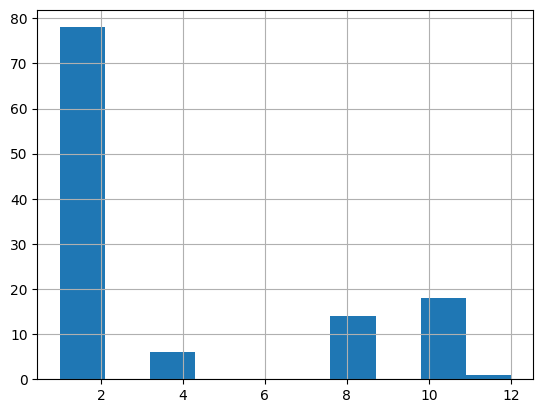

In [69]:

code = 'T7432X'
length_stays = df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == code]['CLM_NUM_DAYS']

length_stays = length_stays[length_stays != 0]

length_stays.hist()

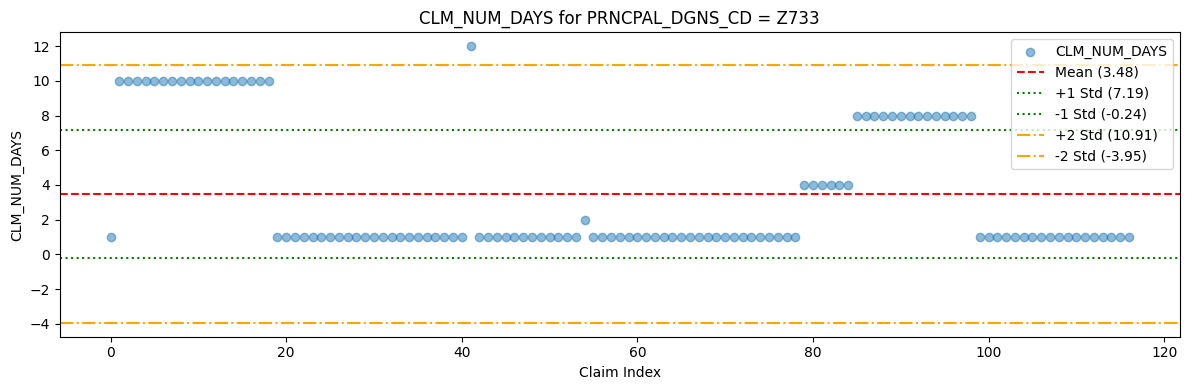

In [70]:
length_stays = df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == code]['CLM_NUM_DAYS']

length_stays = length_stays[length_stays != 0]

# Calculate mean and std
mean_days = length_stays.mean()
std_days = length_stays.std()

# Scatter plot
plt.figure(figsize=(12, 4))
plt.scatter(range(len(length_stays)), length_stays, alpha=0.5, label='CLM_NUM_DAYS')
plt.axhline(mean_days, color='red', linestyle='--', label=f'Mean ({mean_days:.2f})')
plt.axhline(mean_days + std_days, color='green', linestyle=':', label=f'+1 Std ({mean_days + std_days:.2f})')
plt.axhline(mean_days - std_days, color='green', linestyle=':', label=f'-1 Std ({mean_days - std_days:.2f})')
plt.axhline(mean_days + 2*std_days, color='orange', linestyle='-.', label=f'+2 Std ({mean_days + 2*std_days:.2f})')
plt.axhline(mean_days - 2*std_days, color='orange', linestyle='-.', label=f'-2 Std ({mean_days - 2*std_days:.2f})')
plt.title('CLM_NUM_DAYS for PRNCPAL_DGNS_CD = Z733')
plt.xlabel('Claim Index')
plt.ylabel('CLM_NUM_DAYS')
plt.legend()
plt.tight_layout()
plt.show()

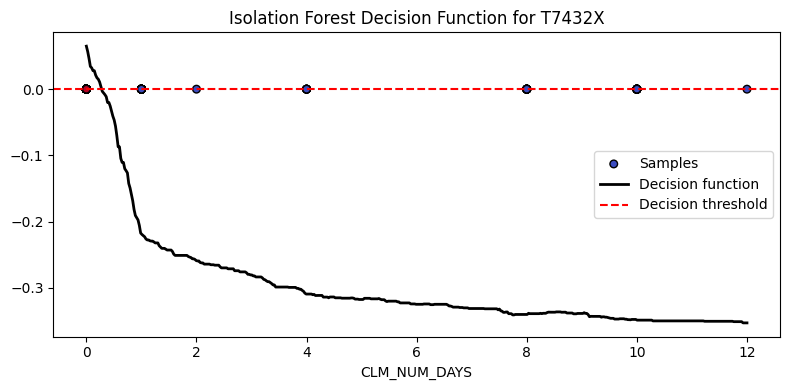

In [82]:
from sklearn.ensemble import IsolationForest
import numpy as np

# length_stays

stays_rs = df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == code]['CLM_NUM_DAYS'].values.reshape(-1, 1)

iso = IsolationForest(random_state=42, contamination='auto')
iso = iso.fit(stays_rs)

# For a single feature, DecisionBoundaryDisplay will show the threshold(s) as vertical lines.
# Let's plot the data and the decision function for the 1D case.
plt.figure(figsize=(8, 4))
plt.scatter(stays_rs, np.zeros_like(stays_rs), c=iso.predict(stays_rs), cmap='coolwarm', s=30, edgecolor='k', label='Samples')
xx = np.linspace(stays_rs.min(), stays_rs.max(), 500).reshape(-1, 1)
decision = iso.decision_function(xx)
plt.plot(xx, decision, color='black', lw=2, label='Decision function')
plt.axhline(0, color='red', linestyle='--', label='Decision threshold')
plt.xlabel('CLM_NUM_DAYS')
plt.title(f'Isolation Forest Decision Function for {code}')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest

# Prepare a DataFrame for each diagnosis code and fit Isolation Forest
outlier_results = []

# need to factor in the other diagnosis codes, not just the primary one, or this is really weak

for code in df_inpatient_subset['PRNCPAL_DGNS_CD'].unique()[0:5]:
    print(f"Processing code: {code}")
    stays = df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == code]['CLM_NUM_DAYS'].values.reshape(-1, 1)
    if len(stays) > 10:  # Only fit if enough samples
        iso = IsolationForest(random_state=42, contamination='auto')
        predictions = iso.fit_predict(stays)
        outlier_mask = predictions == -1
# things go wrong here trying to put it all together
        outlier_indices = df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == code].index[outlier_mask]
        outlier_results.extend(outlier_indices)

# Mark outliers in the DataFrame
df_inpatient_subset['CLM_NUM_DAYS_OUTLIER'] = False
df_inpatient_subset.loc[outlier_results, 'CLM_NUM_DAYS_OUTLIER'] = True

df_inpatient_subset[['PRNCPAL_DGNS_CD', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_OUTLIER']].head(10)

Processing code: S134XX
Processing code: Z3480
Processing code: T7432X
Processing code: S8290X
Processing code: Z3400


,PRNCPAL_DGNS_CD,CLM_NUM_DAYS,CLM_NUM_DAYS_OUTLIER
0,S134XX,0,False
1,Z3480,0,False
2,T7432X,1,True
3,S8290X,0,False
4,S8290X,0,False
5,Z3480,0,False
6,Z3400,0,False
7,R569,0,False
8,S8290X,0,False
9,S8290X,0,False


In [63]:
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_NPI,OP_PHYSN_NPI,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,NCH_BENE_IP_DDCTBL_AMT,PRNCPAL_DGNS_CD,CLM_NUM_DAYS,CLM_NUM_DAYS_OUTLIER
0,-10000010254618,-10000930037831,2015-03-25 00:00:00,2015-03-25 00:00:00,11500,96.65,0.00,1,1578657367,9999870899,9999870899,96.65,2015-03-25 00:00:00,1,4,A,0.0,S134XX,0,False
1,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,17129,6311.88,6276.88,1,1770717738,9999877191,9999877191,6311.88,2015-09-24 00:00:00,1,2,A,0.0,Z3480,0,False
2,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,10052,8545.72,0.00,1,1598783904,9999995399,9999995399,8545.72,2017-05-09 00:00:00,3,1,A,0.0,T7432X,1,True
3,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,15455,1014.85,979.85,1,1033215660,9999856690,9999856690,1014.85,2017-01-14 00:00:00,1,4,A,0.0,S8290X,0,False
4,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,15455,1014.85,979.85,1,1033215660,9999856690,9999856690,1014.85,2017-01-14 00:00:00,1,4,A,0.0,S8290X,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58061,-10000010288008,-10000931485965,2020-01-08 00:00:00,2020-01-14 00:00:00,50243,166.97,131.97,5,1104856095,9999985093,9999985093,166.97,2020-01-08 00:00:00,3,5,A,0.0,T50901A,6,True
58062,-10000010288008,-10000931485967,2020-10-23 00:00:00,2020-10-23 00:00:00,56428,166.97,131.97,5,1750398921,9999253195,9999253195,166.97,2020-10-23 00:00:00,1,2,A,0.0,T50901A,0,False
58063,-10000010288008,-10000931485969,2021-08-22 00:00:00,2021-08-23 00:00:00,56428,166.97,131.97,5,1750398921,9999253195,9999253195,166.97,2021-08-22 00:00:00,1,4,A,0.0,T50901A,1,False
58064,-10000010288008,-10000931485971,2021-09-13 00:00:00,2021-09-16 00:00:00,50243,166.97,131.97,5,1104856095,9999985093,9999985093,166.97,2021-09-13 00:00:00,2,1,A,0.0,T50901A,3,True
